In [24]:
!pip install minio pyarrow pandas matplotlib seaborn plotly

In [ ]:
#-----------------------------Minio COnnection-------------------------------------------------------------------

In [25]:
from minio import Minio
from minio.error import S3Error
import pandas as pd
import io

# Connect to MinIO (Docker service name)
client = Minio(
    "minio:9002",
    access_key="minioadmin",
    secret_key="minioadmin",
    secure=False
)

# Test connection
print("Connecting to MinIO...")
buckets = client.list_buckets()
print("Connection successful. Available buckets:")
for bucket in buckets:
    print(f"  - {bucket.name}")


Connecting to MinIO...
Connection successful. Available buckets:
  - bronze
  - gold
  - silver


In [26]:
silver_bucket = "silver"

print(f"\nParquet files in '{silver_bucket}' bucket:")
parquet_files = []

objects = client.list_objects(silver_bucket, recursive=True)
for obj in objects:
    if obj.object_name.endswith('.parquet'):
        print(f"  Found: {obj.object_name} ({obj.size:,} bytes)")
        parquet_files.append(obj.object_name)

print(f"\nTotal: {len(parquet_files)} Parquet files")



Parquet files in 'silver' bucket:
  Found: merged_data.parquet (94,268 bytes)
  Found: traffic_clean.parquet (26,014 bytes)
  Found: weather_clean.parquet (31,310 bytes)

Total: 3 Parquet files


In [27]:
silver_bucket = "gold"

print(f"\nParquet files in '{silver_bucket}' bucket:")
parquet_files = []

objects = client.list_objects(silver_bucket, recursive=True)
for obj in objects:
    if obj.object_name.endswith('.parquet'):
        print(f"  Found: {obj.object_name} ({obj.size:,} bytes)")
        parquet_files.append(obj.object_name)

print(f"\nTotal: {len(parquet_files)} Parquet files")



Parquet files in 'gold' bucket:
  Found: monte_carlo_results.parquet (2,251 bytes)
  Found: monte_carlo_scenarios.parquet (2,701 bytes)
  Found: traffic_weather_factors.parquet (284,933 bytes)

Total: 3 Parquet files


In [ ]:
#------------------------------------------Monte Carlo Results-----------------------------------------------------

In [30]:
# MONTE CARLO SCENARIOS
import pandas as pd
import io

response = client.get_object("gold", "monte_carlo_scenarios.parquet")
scenarios_df = pd.read_parquet(io.BytesIO(response.read()))
response.close()

print("MONTE CARLO SCENARIOS:")
scenarios_df


MONTE CARLO SCENARIOS:


,scenario,description,mean_traffic,traffic_std,congestion_prob_high,accident_risk_high,threshold_used,n_simulations
0,sunny,"Clear weather, normal conditions",13078.09,2038.26,56.77,1.70,12739.0,10000
1,rainy,"Heavy rain, reduced visibility",8695.55,2050.22,2.41,4.63,12739.0,10000
2,foggy,"Dense fog, low visibility",6781.09,2048.16,0.17,5.39,12739.0,10000
3,snowy,"Snow/ice conditions, severe impact",5147.97,2040.62,0.00,6.92,12739.0,10000


In [34]:
# 📊 MONTE CARLO RESULTS
response = client.get_object("gold", "monte_carlo_results.parquet")
bootstrap_df = pd.read_parquet(io.BytesIO(response.read()))
response.close()

print("MONTE CARLO RESULTS:")
bootstrap_df


MONTE CARLO RESULTS:


,mean_estimate,std_estimate,ci_lower_95,ci_upper_95,simulations
index,,,,,
traffic_id,11360.0177,21.3943,11318.2290,11401.9075,5000.0
vehicle_count,2701.8979,25.8444,2651.3017,2752.0494,5000.0
avg_speed_kmh,55.6610,0.5279,54.6187,56.7106,5000.0
accident_count,5.4153,0.0501,5.3155,5.5106,5000.0
visibility_m_traffic,5647.2167,53.3679,5542.0676,5751.5905,5000.0
weather_id,7369.2377,21.5595,7325.9177,7411.1269,5000.0
temperature_c,13.0282,0.1302,12.7718,13.2847,5000.0
humidity,62.3145,0.3643,61.6051,63.0254,5000.0


In [53]:
# Specialized analysis for Monte Carlo simulation results
mc_df = gold_dataframes["monte_carlo_results.parquet"]

print("MONTE CARLO SIMULATION RESULTS")
print("-" * 40)

# Show simulation parameters and results
print("Columns:", list(mc_df.columns))
print("\nUnique scenarios/simulations:", mc_df.nunique().sum() if 'scenario_id' in mc_df.columns else "N/A")
print("\nSummary statistics:")
mc_df.describe()


MONTE CARLO SIMULATION RESULTS
----------------------------------------
Columns: ['mean_estimate', 'std_estimate', 'ci_lower_95', 'ci_upper_95', 'simulations']

Unique scenarios/simulations: N/A

Summary statistics:


,mean_estimate,std_estimate,ci_lower_95,ci_upper_95,simulations
count,8.000000,8.000000,8.000000,8.000000,8.0
mean,3401.848625,15.404825,3371.478387,3431.900700,5000.0
std,4309.019824,19.050893,4285.979292,4332.051998,0.0
min,5.415300,0.050100,5.315500,5.510600,5000.0
25%,45.002800,0.305775,44.156975,45.854125,5000.0
50%,1382.106200,10.961100,1356.453400,1407.537400,5000.0
75%,6077.721950,22.630725,5988.030125,6166.474600,5000.0
max,11360.017700,53.367900,11318.229000,11401.907500,5000.0


In [ ]:
#-----------------------------------------------Factor Analaysis------------------------------------------------

In [35]:
# FACTOR ANALYSIS RESULTS
response = client.get_object("gold", "traffic_weather_factors.parquet")
factors_df = pd.read_parquet(io.BytesIO(response.read()))
response.close()

print("FACTOR ANALYSIS:")
print(f"Shape: {factors_df.shape}")
print(f"Factors: {[col for col in factors_df.columns if 'Factor' in col]}")
factors_df.head(10)


FACTOR ANALYSIS:
Shape: (4732, 24)
Factors: ['Factor_1_score', 'Factor_2_score', 'Factor_3_score', 'Factor_4_score', 'Factor_5_score']


,traffic_id,date_time_traffic,city,area,vehicle_count,avg_speed_kmh,accident_count,congestion_level,road_condition,visibility_m_traffic,...,humidity,rain_mm,wind_speed_kmh,visibility_m_weather,weather_condition,Factor_1_score,Factor_2_score,Factor_3_score,Factor_4_score,Factor_5_score
0,9001.0,2024-01-01 00:00:00,London,Chelsea,2087.0,115.888010,10.0,High,Dry,7028.0,...,41.0,32.632559,35.666303,5341.0,Fog,0.376019,-0.012611,-1.566057,0.490545,-0.123494
1,9001.0,2024-01-01 00:00:00,London,Chelsea,2087.0,115.888010,10.0,High,Dry,7028.0,...,28.0,7.474442,0.036846,5341.0,Snow,0.376019,-0.012555,-1.565157,0.490051,-0.099525
2,9001.0,2024-01-01 00:00:00,London,Chelsea,2087.0,115.888010,10.0,High,Dry,7028.0,...,34.0,49.460384,69.161197,1412.0,Rain,0.404012,-1.385249,-1.405026,0.451336,-0.000162
3,9001.0,2024-01-01 00:00:00,London,Chelsea,2087.0,115.888010,10.0,High,Dry,7028.0,...,47.0,37.334098,16.095159,5938.0,Clear,0.371765,0.196098,-1.588244,0.495250,-0.081440
4,9001.0,2024-01-01 00:00:00,London,Chelsea,2087.0,115.888010,10.0,High,Dry,7028.0,...,63.0,7.373725,35.304196,4544.0,Fog,0.381696,-0.290882,-1.530637,0.481078,-0.025034
5,9001.0,2024-01-01 00:00:00,London,Chelsea,2087.0,115.888010,10.0,High,Dry,7028.0,...,24.0,25.561978,69.916942,574.0,Fog,0.409981,-1.677771,-1.366739,0.440808,0.131200
6,9001.0,2024-01-01 00:00:00,London,Chelsea,2087.0,115.888010,10.0,High,Dry,7028.0,...,31.0,74.386559,30.068791,3560.0,Clear,0.388705,-0.634450,-1.487009,0.469447,0.093686
7,9003.0,2024-01-01 02:00:00,London,Islington,612.0,-13.344043,1.0,Low,Snowy,9674.0,...,41.0,32.632559,35.666303,5341.0,Fog,1.099642,0.002207,-1.895859,-0.220685,-0.121681
8,9003.0,2024-01-01 02:00:00,London,Islington,612.0,-13.344043,1.0,Low,Snowy,9674.0,...,28.0,7.474442,0.036846,5341.0,Snow,1.099642,0.002263,-1.894960,-0.221179,-0.097712
9,9003.0,2024-01-01 02:00:00,London,Islington,612.0,-13.344043,1.0,Low,Snowy,9674.0,...,34.0,49.460384,69.161197,1412.0,Rain,1.127635,-1.370430,-1.734829,-0.259894,0.001651


In [51]:
# 📊 FACTOR LOADINGS (Simple)
try:
    response = client.get_object("gold", "factor_loadings.parquet")
    loadings_df = pd.read_parquet(io.BytesIO(response.read()))
    response.close()
    display(loadings_df.round(3))
except:
    print("No separate loadings file")
    if 'factors_df' in globals():
        factor_cols = [col for col in factors_df.columns if 'Factor_' in col]
        display(factors_df[factor_cols[:5]].head())


No separate loadings file


,Factor_1_score,Factor_2_score,Factor_3_score,Factor_4_score,Factor_5_score
0,0.376019,-0.012611,-1.566057,0.490545,-0.123494
1,0.376019,-0.012555,-1.565157,0.490051,-0.099525
2,0.404012,-1.385249,-1.405026,0.451336,-0.000162
3,0.371765,0.196098,-1.588244,0.495250,-0.081440
4,0.381696,-0.290882,-1.530637,0.481078,-0.025034


In [ ]:
#----------------------------------------------------Dashboard-----------------------------------------------

/tmp/ipykernel_1566/2784227363.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


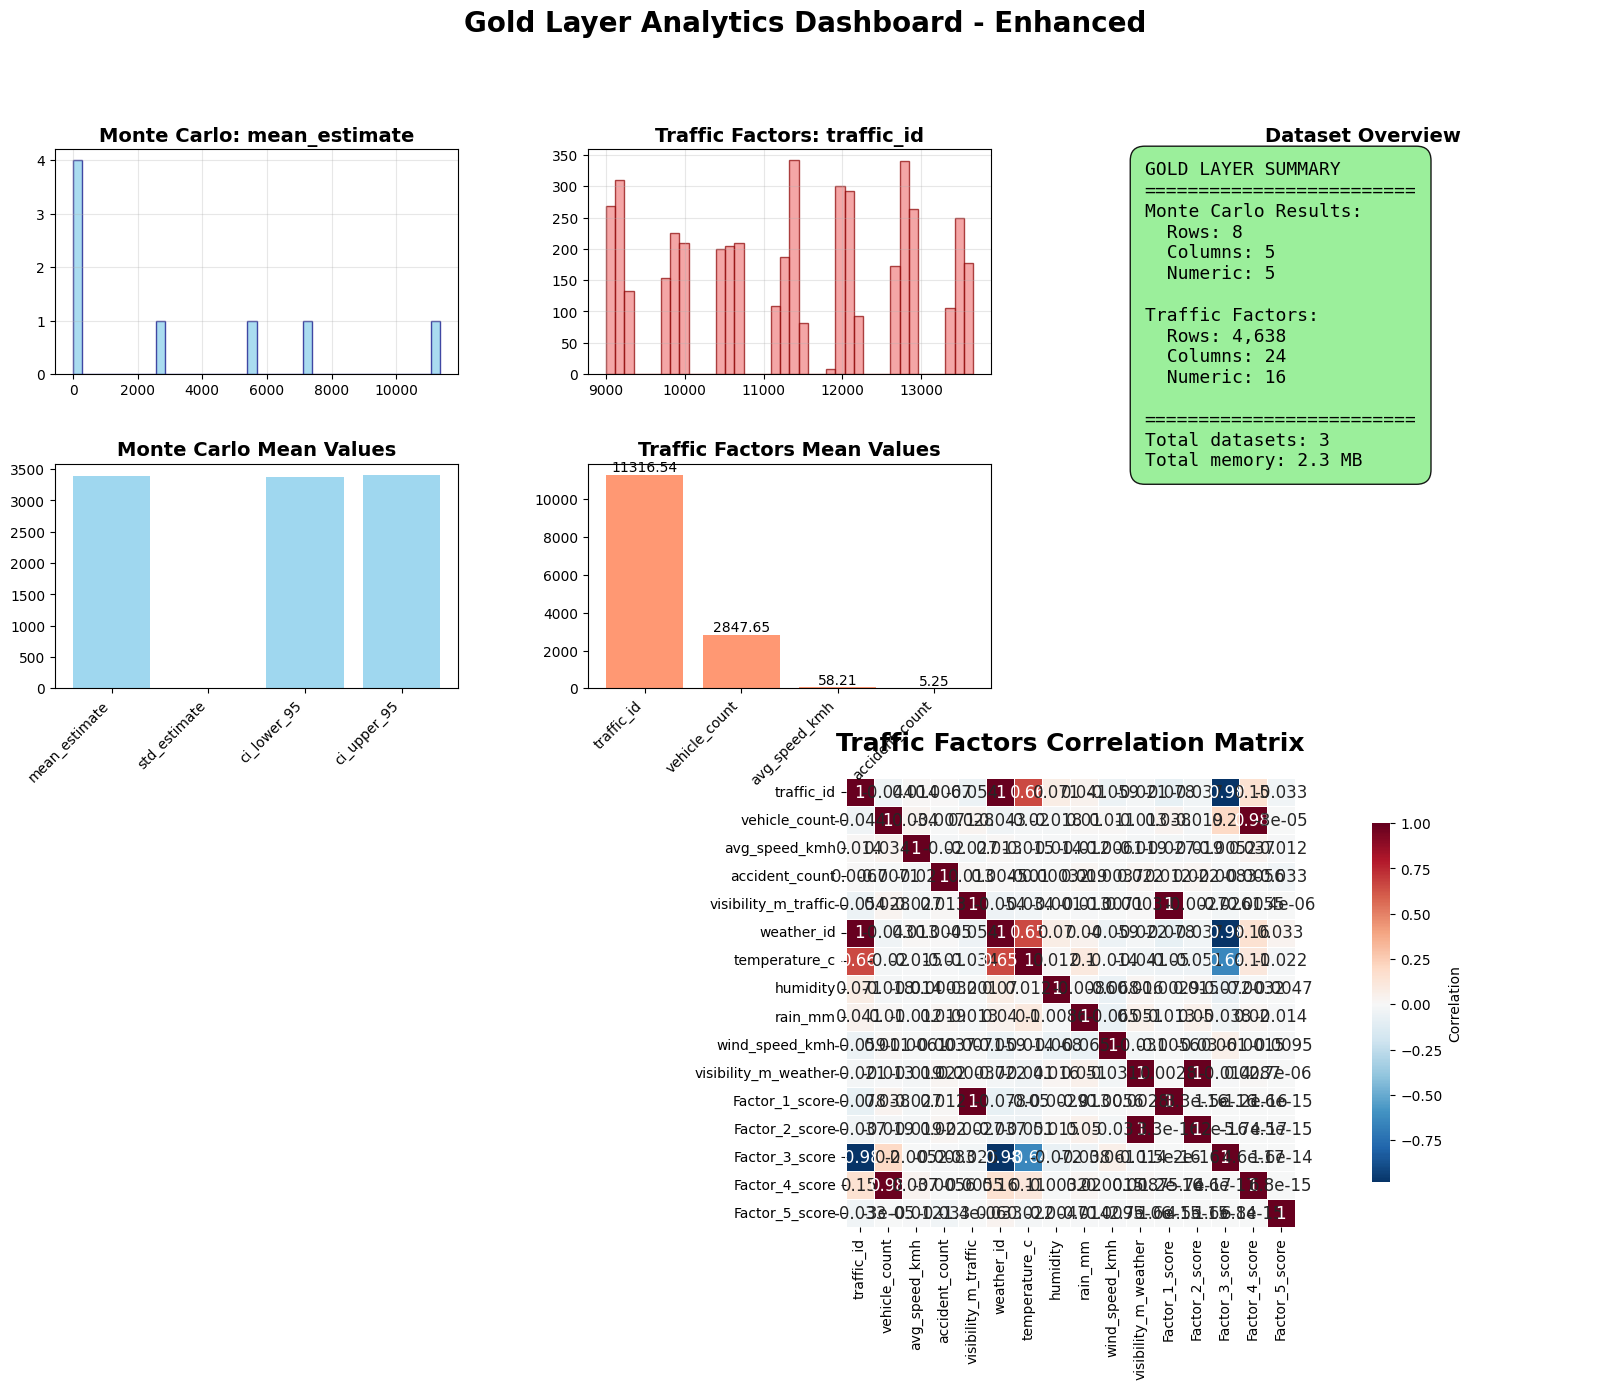

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 2], width_ratios=[1, 1, 1.2], hspace=0.3, wspace=0.3)

fig.suptitle('Gold Layer Analytics Dashboard - Enhanced', fontsize=20, fontweight='bold')

# 1. Monte Carlo visualization
ax1 = fig.add_subplot(gs[0, 0])
mc_numeric_cols = monte_carlo_df.select_dtypes(include=['number']).columns
if len(mc_numeric_cols) > 0:
    mc_col = mc_numeric_cols[0]
    monte_carlo_df[mc_col].hist(ax=ax1, bins=40, alpha=0.7, color='skyblue', edgecolor='navy')
    ax1.set_title(f'Monte Carlo: {mc_col}', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No numeric\ndata', ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('Monte Carlo Results', fontsize=14, fontweight='bold')

# 2. Traffic factors visualization
ax2 = fig.add_subplot(gs[0, 1])
tf_numeric_cols = traffic_factors_df.select_dtypes(include=['number']).columns
if len(tf_numeric_cols) > 0:
    tf_col = tf_numeric_cols[0]
    traffic_factors_df[tf_col].hist(ax=ax2, bins=40, alpha=0.7, color='lightcoral', edgecolor='darkred')
    ax2.set_title(f'Traffic Factors: {tf_col}', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No numeric\ndata', ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Traffic Factors', fontsize=14, fontweight='bold')
# 3. LARGE CORRELATION MATRIX
ax3 = fig.add_subplot(gs[2, :])
if len(tf_numeric_cols) >= 2:
    corr_matrix = traffic_factors_df[tf_numeric_cols].corr()
    sns.heatmap(
        corr_matrix, 
        annot=True,
        annot_kws={'size': 12},
        cmap='RdBu_r',
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
        ax=ax3
    )
    ax3.set_title('Traffic Factors Correlation Matrix', fontsize=18, fontweight='bold', pad=20)
else:
    ax3.text(0.5, 0.5, 'Insufficient\nnumeric columns', ha='center', va='center', transform=ax3.transAxes, fontsize=16)
    ax3.set_title('Correlation Matrix', fontsize=18, fontweight='bold')


# 4. Dataset summary
ax4 = fig.add_subplot(gs[0, 2])
mc_count = len(monte_carlo_df.select_dtypes(include=['number']).columns)
tf_count = len(traffic_factors_df.select_dtypes(include=['number']).columns)

summary_text = f"""GOLD LAYER SUMMARY
{'='*25}
Monte Carlo Results:
  Rows: {monte_carlo_df.shape[0]:,}
  Columns: {monte_carlo_df.shape[1]}
  Numeric: {mc_count}

Traffic Factors:
  Rows: {traffic_factors_df.shape[0]:,}
  Columns: {traffic_factors_df.shape[1]}
  Numeric: {tf_count}

{'='*25}
Total datasets: {len(gold_dataframes)}
Total memory: {(monte_carlo_df.memory_usage(deep=True).sum() + 
                traffic_factors_df.memory_usage(deep=True).sum()) / 1024**2:.1f} MB"""
ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=13,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.8', facecolor='lightgreen', alpha=0.9))
ax4.set_title('Dataset Overview', fontsize=14, fontweight='bold')
ax4.axis('off')

# 5. Monte Carlo statistics
ax5 = fig.add_subplot(gs[1, 0])
if len(mc_numeric_cols) > 0:
    mc_stats = monte_carlo_df[mc_numeric_cols[:4]].describe().iloc[1]  # mean row
    bars = ax5.bar(range(len(mc_stats)), mc_stats.values, color='skyblue', alpha=0.8)
    ax5.set_title('Monte Carlo Mean Values', fontsize=14, fontweight='bold')
    ax5.set_xticks(range(len(mc_stats)))
    ax5.set_xticklabels(mc_stats.index, rotation=45, ha='right')
else:
    ax5.text(0.5, 0.5, 'No numeric\ndata', ha='center', va='center', fontsize=12)
    ax5.set_title('Monte Carlo Stats', fontsize=14)

# 6. FIXED Traffic factors statistics
ax6 = fig.add_subplot(gs[1, 1])
if len(tf_numeric_cols) > 0:
    # Fixed: Take first 4 numeric columns as list
    tf_cols_subset = tf_numeric_cols[:4].tolist()
    tf_stats = traffic_factors_df[tf_cols_subset].describe().iloc[1]  # mean row
    bars = ax6.bar(range(len(tf_stats)), tf_stats.values, color='coral', alpha=0.8)
    ax6.set_title('Traffic Factors Mean Values', fontsize=14, fontweight='bold')
    ax6.set_xticks(range(len(tf_stats)))
    ax6.set_xticklabels(tf_stats.index, rotation=45, ha='right')
    # Add value labels on bars
    for bar, val in zip(bars, tf_stats.values):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.2f}', ha='center', va='bottom', fontsize=10)
else:
    ax6.text(0.5, 0.5, 'No numeric\ndata', ha='center', va='center', fontsize=12)
    ax6.set_title('Traffic Factors Stats', fontsize=14)

plt.tight_layout()
plt.show()

In [57]:
#------------------------------------Monte Carlo Analaysis---------------------------------------------

🚦 Loading scenarios...
✔ 4 scenarios loaded


,scenario,description,mean_traffic,traffic_std,congestion_prob_high,accident_risk_high,threshold_used,n_simulations
0,sunny,"Clear weather, normal conditions",13078.09,2038.26,56.77,1.70,12739.0,10000
1,rainy,"Heavy rain, reduced visibility",8695.55,2050.22,2.41,4.63,12739.0,10000
2,foggy,"Dense fog, low visibility",6781.09,2048.16,0.17,5.39,12739.0,10000
3,snowy,"Snow/ice conditions, severe impact",5147.97,2040.62,0.00,6.92,12739.0,10000


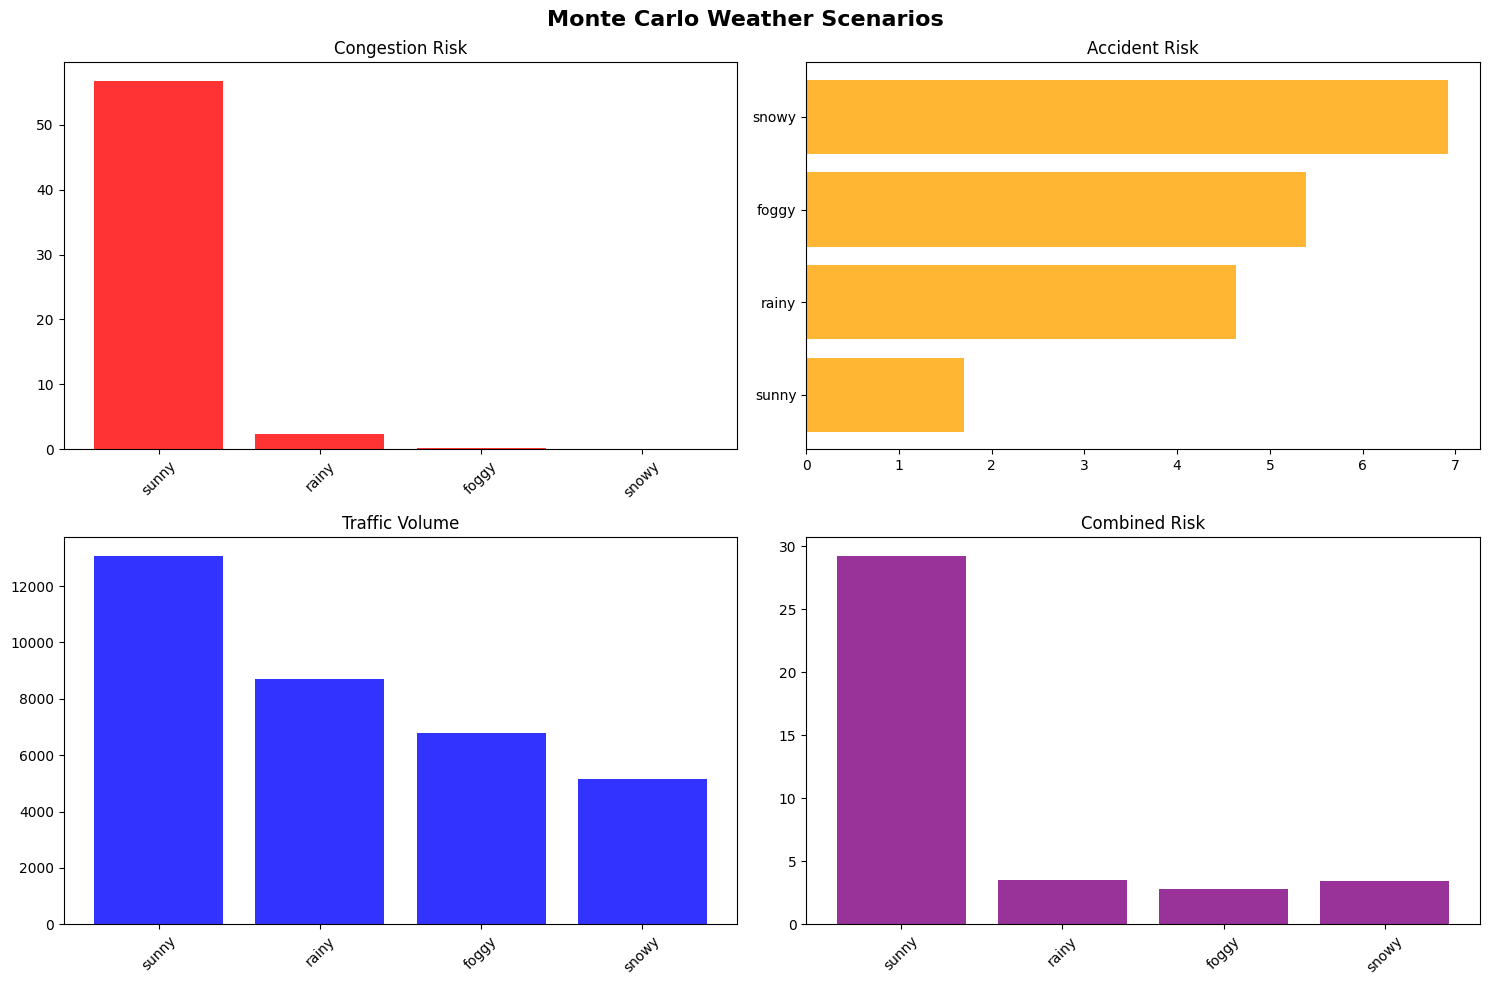


📊 Bootstrap results...
✔ Bootstrap: (8, 5)
Columns: ['mean_estimate', 'std_estimate', 'ci_lower_95', 'ci_upper_95', 'simulations']


,mean_estimate,std_estimate,ci_lower_95,ci_upper_95,simulations
index,,,,,
traffic_id,11360.0177,21.3943,11318.2290,11401.9075,5000.0
vehicle_count,2701.8979,25.8444,2651.3017,2752.0494,5000.0
avg_speed_kmh,55.6610,0.5279,54.6187,56.7106,5000.0
accident_count,5.4153,0.0501,5.3155,5.5106,5000.0
visibility_m_traffic,5647.2167,53.3679,5542.0676,5751.5905,5000.0


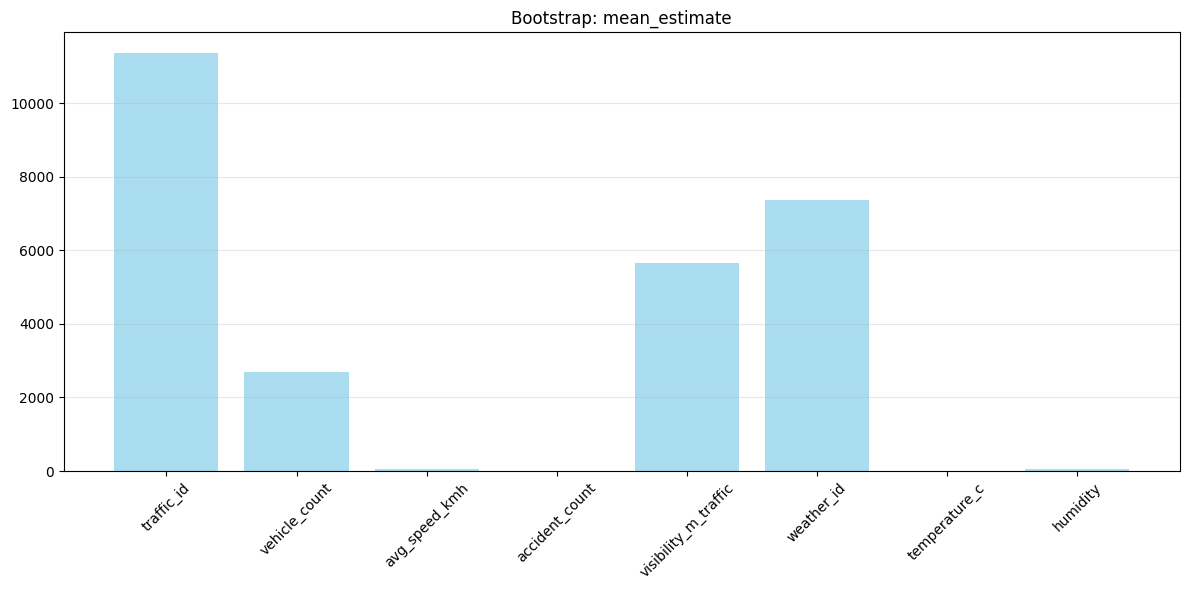

✅ Analysis complete!


In [61]:
# ================================================
# MONTE CARLO ANALYSIS (SAFE COLUMNS)
# ================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# 1. SCENARIOS (Safe Load + Visualize)
print("🚦 Loading scenarios...")
try:
    scenario_obj = client.get_object("gold", "monte_carlo_scenarios.parquet")
    df_scenarios = pd.read_parquet(io.BytesIO(scenario_obj.read()))
    print(f"✔ {len(df_scenarios)} scenarios loaded")
    display(df_scenarios.round(2))
except:
    print("❌ Scenarios missing")
    df_scenarios = pd.DataFrame()

# Safe visualization
if not df_scenarios.empty:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Monte Carlo Weather Scenarios', fontsize=16, fontweight='bold')
    
    # Safe column checks
    cols = df_scenarios.columns
    x = range(len(df_scenarios))
    
    # 1. Congestion (if exists)
    if 'congestion_prob_high' in cols and 'scenario' in cols:
        axes[0,0].bar(df_scenarios['scenario'], df_scenarios['congestion_prob_high'], 
                     color='red', alpha=0.8)
        axes[0,0].set_title('Congestion Risk')
        axes[0,0].tick_params('x', rotation=45)
    
    # 2. Accidents (if exists)
    if 'accident_risk_high' in cols and 'scenario' in cols:
        axes[0,1].barh(df_scenarios['scenario'], df_scenarios['accident_risk_high'], 
                      color='orange', alpha=0.8)
        axes[0,1].set_title('Accident Risk')
    
    # 3. Traffic (if exists)
    if 'mean_traffic' in cols:
        axes[1,0].bar(df_scenarios['scenario'], df_scenarios['mean_traffic'], 
                     color='blue', alpha=0.8)
        axes[1,0].set_title('Traffic Volume')
        axes[1,0].tick_params('x', rotation=45)
    
    # 4. Combined risk (if both exist)
    if 'congestion_prob_high' in cols and 'accident_risk_high' in cols:
        risk = (df_scenarios['congestion_prob_high'] + df_scenarios['accident_risk_high']) / 2
        axes[1,1].bar(df_scenarios['scenario'], risk, color='purple', alpha=0.8)
        axes[1,1].set_title('Combined Risk')
        axes[1,1].tick_params('x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# 2. BOOTSTRAP (Safe Load + Visualize)
print("\n📊 Bootstrap results...")
try:
    bootstrap_obj = client.get_object("gold", "monte_carlo_results.parquet")
    df_bootstrap = pd.read_parquet(io.BytesIO(bootstrap_obj.read()))
    print(f"✔ Bootstrap: {df_bootstrap.shape}")
    print("Columns:", list(df_bootstrap.columns))
    display(df_bootstrap.head())
    
    # Safe plot - find numeric columns
    numeric_cols = df_bootstrap.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0 and len(df_bootstrap) > 0:
        plt.figure(figsize=(12, 6))
        x = range(len(df_bootstrap))
        
        # Try mean_est first, fallback to first numeric
        if 'mean_est' in df_bootstrap.columns:
            y = df_bootstrap['mean_est']
            err_lower = df_bootstrap.get('ci_lower', 0)
            err_upper = df_bootstrap.get('ci_upper', 0)
            plt.bar(x, y, yerr=[y-err_lower, err_upper-y], capsize=5, 
                   color='skyblue', alpha=0.7, edgecolor='navy')
            plt.title('Bootstrap Confidence Intervals')
        else:
            plt.bar(x, df_bootstrap[numeric_cols[0]], color='skyblue', alpha=0.7)
            plt.title(f'Bootstrap: {numeric_cols[0]}')
        
        plt.xticks(x, df_bootstrap.index, rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Bootstrap error: {e}")

print(" Analysis complete!")
